In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_curve,
    auc,
    RocCurveDisplay
)

from sklearn.model_selection import cross_val_score

import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np

In [ ]:
X_train_scaled = np.load('../data/processed/X_train_scaled.npy')
X_test_scaled  = np.load('../data/processed/X_test_scaled.npy')
y_train = np.load('../data/processed/y_train.npy')
y_test  = np.load('../data/processed/y_test.npy')

print("Training set shape:", X_train_scaled.shape) 
print("Test set shape:", X_test_scaled.shape)      

Training set shape: (455, 30)
Test set shape: (114, 30)


In [ ]:
# Dictionary to store models and their names (makes comparison easy)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM (Linear)": SVC(kernel='linear', probability=True, random_state=42) 
}

# Train and store predictions
results = {}
predictions = {}
probabilities = {}  # For ROC curves

for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_train_scaled, y_train)
    
    # Predict on test set
    y_pred = model.predict(X_test_scaled)
    predictions[name] = y_pred
    
    # Probabilities (for ROC) 
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Probability of malignant (class 1)
    else:
        y_prob = model.decision_function(X_test_scaled)    # In case of Linear SVM
    probabilities[name] = y_prob
    
    # Basic accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name} Test Accuracy: {acc:.4f}")


Training Logistic Regression...
Logistic Regression Test Accuracy: 0.9649

Training Decision Tree...
Decision Tree Test Accuracy: 0.9211

Training Random Forest...
Random Forest Test Accuracy: 0.9737

Training SVM (Linear)...
SVM (Linear) Test Accuracy: 0.9649


In [4]:
# Print full report for each model
for name in models:
    print(f"\n=== {name} ===")
    print(classification_report(y_test, predictions[name], target_names=['Benign (0)', 'Malignant (1)']))


=== Logistic Regression ===
               precision    recall  f1-score   support

   Benign (0)       0.96      0.99      0.97        72
Malignant (1)       0.97      0.93      0.95        42

     accuracy                           0.96       114
    macro avg       0.97      0.96      0.96       114
 weighted avg       0.97      0.96      0.96       114


=== Decision Tree ===
               precision    recall  f1-score   support

   Benign (0)       0.91      0.97      0.94        72
Malignant (1)       0.95      0.83      0.89        42

     accuracy                           0.92       114
    macro avg       0.93      0.90      0.91       114
 weighted avg       0.92      0.92      0.92       114


=== Random Forest ===
               precision    recall  f1-score   support

   Benign (0)       0.96      1.00      0.98        72
Malignant (1)       1.00      0.93      0.96        42

     accuracy                           0.97       114
    macro avg       0.98      0.96   

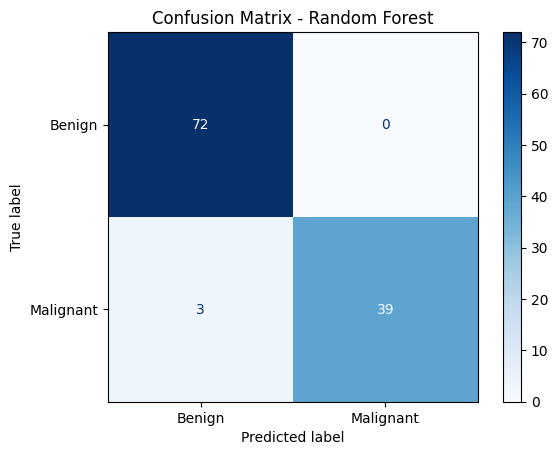

In [ ]:
# Pick the best model and plot its confusion matrix
best_model_name = max(results, key=results.get)  
best_pred = predictions[best_model_name]

cm = confusion_matrix(y_test, best_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign', 'Malignant'])
disp.plot(cmap='Blues')
plt.title(f"Confusion Matrix - {best_model_name}")
plt.show()

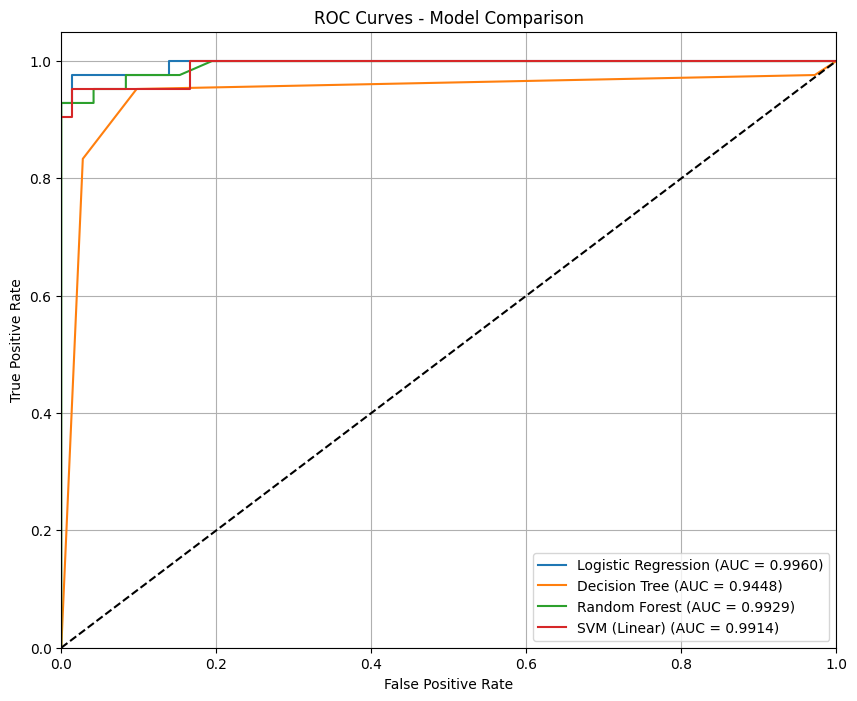

In [6]:
plt.figure(figsize=(10, 8))

for name in models:
    fpr, tpr, _ = roc_curve(y_test, probabilities[name])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
import pandas as pd

# Reuse the same model definitions (with same random_state for fairness)
cv_results = []

print("Running 5-Fold Cross-Validation on Training Data...\n")

for name, model in models.items():
    # Important: For fair comparison, we use the **same model instance type** as before
    # But we create fresh instances here so CV doesn't leak state
    if name == "Logistic Regression":
        cv_model = LogisticRegression(max_iter=1000, random_state=42)
    elif name == "Decision Tree":
        cv_model = DecisionTreeClassifier(max_depth=5, random_state=42)
    elif name == "Random Forest":
        cv_model = RandomForestClassifier(n_estimators=100, random_state=42)
    elif name == "SVM (Linear)":
        cv_model = SVC(kernel='linear', random_state=42)  # Note: SVC doesn't have probability by default here
    
    # Run 5-fold CV (using accuracy as scoring metric)
    scores = cross_val_score(cv_model, X_train_scaled, y_train, cv=5, scoring='accuracy', n_jobs=-1)
    
    mean_score = scores.mean()
    std_score = scores.std()
    
    cv_results.append({
        'Model': name,
        'CV Mean Accuracy': mean_score,
        'CV Std Deviation': std_score,
        'Min Fold': scores.min(),
        'Max Fold': scores.max()
    })
    
    print(f"{name}:")
    print(f"  → Mean Accuracy: {mean_score:.4f} (± {std_score:.4f})")
    print(f"  → Fold scores: {np.round(scores, 4)}\n")

Running 5-Fold Cross-Validation on Training Data...

Logistic Regression:
  → Mean Accuracy: 0.9714 (± 0.0112)
  → Fold scores: [0.967 0.989 0.956 0.978 0.967]

Decision Tree:
  → Mean Accuracy: 0.9341 (± 0.0326)
  → Fold scores: [0.967  0.967  0.9011 0.9451 0.8901]

Random Forest:
  → Mean Accuracy: 0.9626 (± 0.0338)
  → Fold scores: [1.     0.989  0.9341 0.978  0.9121]

SVM (Linear):
  → Mean Accuracy: 0.9626 (± 0.0164)
  → Fold scores: [0.967  0.989  0.9451 0.967  0.9451]



In [ ]:
import joblib

best_model_name = "Logistic Regression"
best_model = models[best_model_name]

# Save the trained model
joblib.dump(best_model, f'../models/best_model_{best_model_name.replace(" ", "_")}.joblib')
print(f"Saved best model: {best_model_name}")

# Save predictions and probabilities for later analysis
import pandas as pd
results_df = pd.DataFrame({
    'True_Label': y_test,
    'Predicted': predictions[best_model_name],
    'Probability_Malignant': probabilities[best_model_name]
})
results_df.to_csv(f'../data/test_predictions_{best_model_name.replace(" ", "_")}.csv', index=False)
print("Saved test predictions to CSV")

Saved best model: Logistic Regression
Saved test predictions to CSV
